In [2]:
# Import all the necessary files!
import os
import path
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [2]:
# Download the inception v3 weights

#!wget --no-check-certificate \
#    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [4]:
# Get the Horse or Human dataset
#!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
#!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  


# import os
# import zipfile

# try:
#     os.mkdir("/tmp/horse-or-human/")
# except:
#     pass

# local_zip = '/tmp/horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp/horse-or-human/training')
# zip_ref.close()

# local_zip = '/tmp/validation-horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp/horse-or-human/validation')
# zip_ref.close()

In [3]:


# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable=False
  # Your Code Here
  
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
last_layer = pre_trained_model.get_layer("mixed7")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [5]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

      

In [6]:


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(inputs=[pre_trained_model.inputs], outputs=x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
train_horses_dir = '/tmp/horse-or-human/training/horses/'
train_humans_dir = '/tmp/horse-or-human/training/humans/'
validation_horses_dir = '/tmp/horse-or-human/validation/horses/'
validation_humans_dir = '/tmp/horse-or-human/validation/humans/'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [10]:
# Define our example directories and files
train_dir = '/tmp/horse-or-human/training'
validation_dir = '/tmp/horse-or-human/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150, 150)
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150, 150)
)   

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [11]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)

callbacks = [myCallback()]
history = model.fit(
    train_generator, 
    epochs=100, 
    validation_data=validation_generator, 
    callbacks=[callbacks]
)

Epoch 1/100
52/52 [==============================] - 10s 197ms/step - loss: 0.1517 - accuracy: 0.9484 - val_loss: 0.0478 - val_accuracy: 0.9844
Epoch 2/100
52/52 [==============================] - 8s 162ms/step - loss: 0.0328 - accuracy: 0.9883 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 3/100
52/52 [==============================] - 9s 167ms/step - loss: 0.0118 - accuracy: 0.9951 - val_loss: 0.0330 - val_accuracy: 0.9883
Epoch 4/100
52/52 [==============================] - 9s 172ms/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 0.0608 - val_accuracy: 0.9805
Epoch 5/100
52/52 [==============================] - 9s 170ms/step - loss: 0.0068 - accuracy: 0.9971 - val_loss: 0.0194 - val_accuracy: 0.9922
Epoch 6/100
52/52 [==============================] - 9s 164ms/step - loss: 0.0065 - accuracy: 0.9971 - val_loss: 0.0567 - val_accuracy: 0.9844
Epoch 7/100
52/52 [==============================] - 9s 164ms/step - loss: 0.0311 - accuracy: 0.9912 - val_loss: 0.0233 - val_accuracy: 0.992

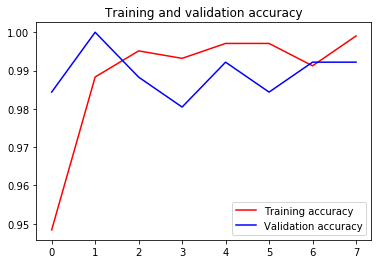

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()